In [830]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment as linear_assignment

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In [831]:
def sup_con_loss(features, labels, temp=1):
    
    labels = labels.contiguous().view(-1, 1)
    
    dot_matrix = torch.matmul(features, features.T) / temp
    
    mask = ~torch.eye(len(features), dtype=bool)
    
    exp_matrix = torch.exp(dot_matrix) * mask
    
    positive_mask = (labels == labels.T) & mask
    
    log_denom = torch.log(exp_matrix.sum(dim=1, keepdim=True))
    
    log_proba = dot_matrix - log_denom
    
    losses = (positive_mask * log_proba).sum(dim=1) / (positive_mask.sum(dim=1) + 1e-8)
    
    loss = - losses.mean()
    
    return loss

In [804]:
class BASEHead(nn.Module):
    def __init__(self, in_dim=512, hidden_dim=2048, bottleneck_dim=256, code_dim=12, nlayers=3):
        super().__init__()
        layers = []

        if nlayers == 1:
            layers.append(nn.Linear(in_dim, bottleneck_dim))
        else:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            layers.append(nn.BatchNorm1d(bottleneck_dim))
            layers.append(nn.GELU())

        self.mlp = nn.Sequential(*layers)
        self.hash_head = nn.Linear(bottleneck_dim, code_dim, bias=False)
        self.bn = nn.BatchNorm1d(code_dim)

    def forward(self, x):
        x = self.mlp(x)
        x = self.hash_head(x)
        x = self.bn(x)
        x = nn.functional.normalize(x, dim=1)
        return x

In [826]:
class BaselineModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[512, 512, 256], dropout=0.3):
        super().__init__()

        layers = []
        in_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim,hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim

        self.mlp = nn.Sequential(*layers)

        self.head = nn.Linear(in_dim,output_dim,bias=False)

        
    def forward(self, x):
        x = self.mlp(x)
        x = self.head(x)
        x = nn.functional.normalize(x, dim=1)
        return x, x, x

In [827]:
class HASHHead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[512, 512, 256], dropout=0.3):
        super().__init__()

        layers = []
        in_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim,hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = hidden_dim

        self.mlp = nn.Sequential(*layers)

        self.hash = nn.Linear(in_dim,output_dim,bias=False)
        self.variance = nn.Linear(in_dim,output_dim,bias=False)
        self.bn_h = nn.BatchNorm1d(output_dim)
        self.bn_v = nn.BatchNorm1d(output_dim)

        
    def forward(self, x):
        x = self.mlp(x)
        h = self.hash(x)
        v = self.variance(x)

        h = self.bn_h(h)
        v = self.bn_v(v)

        # From OCD SMILE code
        v = v / (nn.Tanh()(v * 1))
        h = nn.Tanh()(h * 1) 

        x = h * v
        
        x = nn.functional.normalize(x, dim=1)
        return x, h, v

In [828]:
def cluster_acc(y_true, y_pred, return_ind=False):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(int)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    if return_ind:
        return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size, ind, w
    else:
        return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def split_cluster_acc_v1(y_true, y_pred, mask):

    """
    Evaluate clustering metrics on two subsets of data, as defined by the mask 'mask'
    (Mask usually corresponding to `Old' and `New' classes in GCD setting)
    :param targets: All ground truth labels
    :param preds: All predictions
    :param mask: Mask defining two subsets
    :return:
    """

    mask = mask.astype(bool)
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    weight = mask.mean()

    old_acc = cluster_acc(y_true[mask], y_pred[mask])
    new_acc = cluster_acc(y_true[~mask], y_pred[~mask])
    total_acc = weight * old_acc + (1 - weight) * new_acc

    return total_acc, old_acc, new_acc

def split_cluster_acc_v2(y_true, y_pred, mask):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    First compute linear assignment on all data, then look at how good the accuracy is on subsets

    # Arguments
        mask: Which instances come from old classes (True) and which ones come from new classes (False)
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    mask = mask.astype(bool)
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)

    old_classes_gt = set(y_true[mask])
    new_classes_gt = set(y_true[~mask])

    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    ind_map = {j: i for i, j in ind}
    total_acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

    old_acc = 0
    total_old_instances = 0
    for i in old_classes_gt:
        old_acc += w[ind_map[i], i]
        total_old_instances += sum(w[:, i])
    old_acc /= total_old_instances

    new_acc = 0
    total_new_instances = 0
    for i in new_classes_gt:
        new_acc += w[ind_map[i], i]
        total_new_instances += sum(w[:, i])
    new_acc /= total_new_instances

    return total_acc, old_acc, new_acc


In [829]:
def create_cluster_ids(output, y):
    
    hashes = torch.where(output > 0, 1, 0)
    unique_hashes = torch.unique(hashes, dim=0)
    hashes_bin = np.array(hashes)
    cluster_ids = np.array([int("".join(map(str, row)), 2) for row in hashes_bin])

    _, new_labels = np.unique(cluster_ids, return_inverse=True)

    return new_labels

In [846]:
input_dim = 20
output_dim = 12
hidden_dims = [1024, 512, 256]
dropout = 0.3
classes = 8
train_class_prop = 0.75
test_size = 0.25
epochs = 1000
model_type = 'baseline' # baseline, SMILE

model = BaselineModel(input_dim, output_dim, hidden_dims, dropout)
# model = HASHHead(input_dim, output_dim, hidden_dims, dropout)


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



X, y = make_classification(n_samples=4000,
                           n_features=input_dim,
                           n_informative=int(0.75*input_dim),
                           n_redundant=input_dim-int(0.75*input_dim),
                           n_classes=classes,
                           n_clusters_per_class=2,
                           random_state=42)


train_classes = int(train_class_prop*classes)
train_classes = np.random.choice(np.unique(y),size=train_classes,replace=False)
test_classes = np.array(list(set(np.unique(y)) - set(train_classes)))

df = pd.DataFrame(data=np.hstack([X,y[:,np.newaxis]]), columns=[f'feature_{i}' for i in range(X.shape[1])] + ['y'])
df['y'] = df['y'].astype('int')

indices = np.array(len(y))

tr_class = df.loc[df['y'].isin(train_classes)]
te_class = df.loc[df['y'].isin(test_classes)]

training_indices = np.random.choice(tr_class.index,size=int( (1 - test_size) * len(tr_class)), replace=False)
testing_indices = np.delete(df.index, training_indices)

df_train = df.loc[training_indices]
X_train = df_train.drop(columns='y')
y_train = df_train['y']

df_test = df.loc[testing_indices]
X_test = df_test.drop(columns='y')
y_test = df_test['y']



X = torch.Tensor(X)
y = torch.Tensor(y)

X_train = torch.Tensor(X_train.values)
y_train = torch.tensor(y_train.values).long().squeeze()

X_test = torch.Tensor(X_test.values)
y_test = torch.tensor(y_test.values).long().squeeze()


model.train()

train_aris = []
train_nmis = []
train_amis = []

test_aris = []
test_nmis = []
test_amis = []

weighted_scores = []
old_scores = []
new_scores = []

global_scores = []
old_global_scores = []
new_global_scores = []

unique_training_hashes = []
unique_testing_hashes = []

losses = []
for i in tqdm(range(epochs), desc='Training Model'):

    if model_type == 'baseline':
        training_features, _, _ = model(X_train)
        testing_features, _, _ = model(X_test)
        sc_loss = sup_con_loss(training_features, y_train, temp=0.2)
        reg_loss = 0
        
    elif model_type == 'SMILE':
        training_features, training_hash_features, v = model(X_train)
        testing_features, testing_hash_features, _ = model(X_test)
        sc_loss = sup_con_loss(training_features, y_train, temp=0.2)

        reg_loss = (1 - torch.abs(training_hash_features)).mean()
        

    loss = sc_loss * 1 + reg_loss * 3
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Create Cluster ids for train, test, and full data sets
    training_cluster_ids = create_cluster_ids(training_features, y_train)
    testing_cluster_ids = create_cluster_ids(testing_features, y_test)
    
    # # Full dataset clusters
    # features, _, _ = model(X)
    # full_cluster_ids = create_cluster_ids(features, y)
    
    # Report ARI, NMI, and AMI for training and testing splits
    train_aris.append(adjusted_rand_score(y_train, training_cluster_ids))
    train_nmis.append(normalized_mutual_info_score(y_train, training_cluster_ids))
    train_amis.append(adjusted_mutual_info_score(y_train, training_cluster_ids))

    test_aris.append(adjusted_rand_score(y_test, testing_cluster_ids))
    test_nmis.append(normalized_mutual_info_score(y_test, testing_cluster_ids))
    test_amis.append(adjusted_mutual_info_score(y_test, testing_cluster_ids))

    # Report category discovery metrics
    old_inds = df_test.loc[df_test['y'].isin(train_classes)].index
    mask = np.isin(df_test.index,old_inds)
    
    total_acc, old_acc, new_acc = split_cluster_acc_v1(np.array(y_test), testing_cluster_ids, mask)
    weighted_scores.append(total_acc)
    old_scores.append(old_acc)
    new_scores.append(new_acc)
    
    total_acc, old_acc, new_acc = split_cluster_acc_v2(np.array(y_test), testing_cluster_ids, mask)
    global_scores.append(total_acc)
    old_global_scores.append(old_acc)
    new_global_scores.append(new_acc)

    unique_training_hashes.append(len(np.unique(training_cluster_ids)))
    unique_testing_hashes.append(len(np.unique(testing_cluster_ids)))

Training Model: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:46<00:00,  1.90it/s]


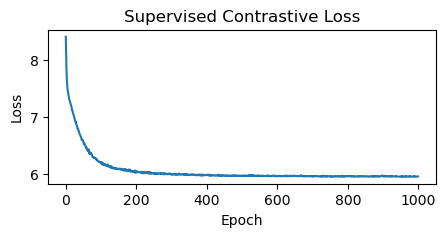

In [847]:
plt.figure(figsize=(5,2))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Supervised Contrastive Loss')
plt.show()

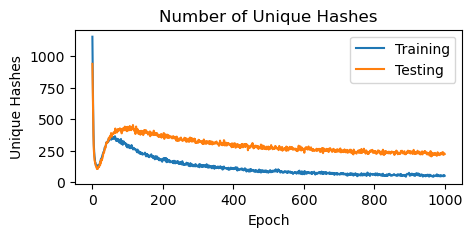

In [848]:
plt.figure(figsize=(5,2))
plt.plot(unique_training_hashes,label='Training')
plt.plot(unique_testing_hashes,label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Unique Hashes')
plt.title('Number of Unique Hashes')
plt.legend()
plt.show()

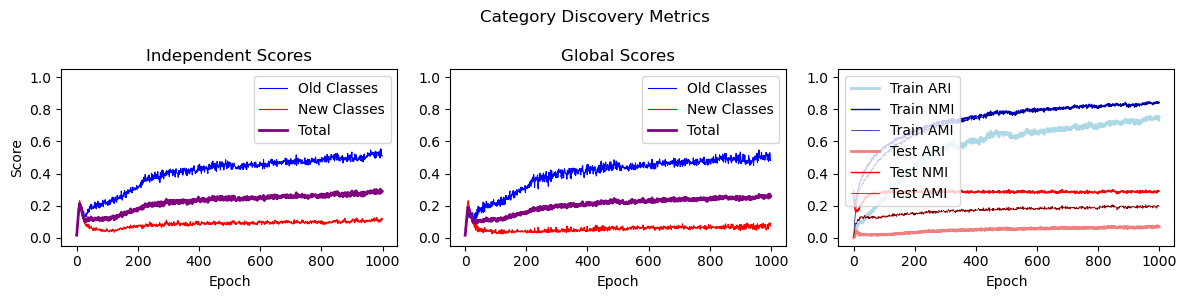

In [849]:
figs, axes = plt.subplots(1,3,figsize=(12,3))

minimum = -0.05
maximum = 1.05

# Plot independent & weighted scores
axes[0].plot(old_scores,linewidth=0.8,color='blue',label='Old Classes')
axes[0].plot(new_scores,linewidth=0.8,color='red',label='New Classes')
axes[0].plot(weighted_scores,linewidth=2,color='purple',label='Total')
axes[0].set_title('Independent Scores')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Score')
axes[0].set_ylim([minimum, maximum])
axes[0].legend()

# Plot global scores
axes[1].plot(old_global_scores,linewidth=0.8,color='blue',label='Old Classes')
axes[1].plot(new_global_scores,linewidth=0.8,color='red',label='New Classes')
axes[1].plot(global_scores,linewidth=2,color='purple',label='Total')
axes[1].set_title('Global Scores')
axes[1].set_xlabel('Epoch')
axes[1].set_ylim([minimum, maximum])
axes[1].legend()

# Plot training and testing aris
axes[2].plot(train_aris,linewidth=2,color='lightblue',label='Train ARI')
axes[2].plot(train_nmis,linewidth=1,color='mediumblue',label='Train NMI')
axes[2].plot(train_amis,linewidth=0.5,color='darkblue',label='Train AMI')
axes[2].plot(test_aris,linewidth=2,color='lightcoral',label='Test ARI')
axes[2].plot(test_nmis,linewidth=1,color='red',label='Test NMI')
axes[2].plot(test_amis,linewidth=0.5,color='darkred',label='Test AMI')
axes[2].set_title('')
axes[2].set_xlabel('Epoch')
axes[2].set_ylim([minimum, maximum])
axes[2].legend()


plt.suptitle('Category Discovery Metrics')
plt.tight_layout()
plt.show()

### Single Test

In [744]:
data = {'y' : np.array(y_train), 'cluster_ids' : training_cluster_ids}
df = pd.DataFrame(data=data)
df.groupby('y')['cluster_ids'].agg('value_counts')

y  cluster_ids
0  12             263
   10             103
   9                1
1  1              119
   3              109
   7               67
   5               53
   4               12
   6                9
   2                7
   0                1
3  8              373
   14               8
4  11             350
   13              21
Name: count, dtype: int64

In [747]:
data = {'y' : np.array(y_test), 'cluster_ids' : testing_cluster_ids}
df = pd.DataFrame(data=data)
df.groupby('y')['cluster_ids'].agg('value_counts')

y  cluster_ids
0  23             69
   16             34
   9               5
   1               3
   11              3
                  ..
5  20              1
   21              1
   24              1
   27              1
   29              1
Name: count, Length: 121, dtype: int64